In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
spark = (
    SparkSession.builder.appName("Desafio - pergunta 1 - Spark SQL")
    .config('spark.sql.repl.eagerEval.enabled', True)
    .config("spark.sql.shuffle.partitions", "8")
    .getOrCreate()
)

In [3]:
train = spark.read.csv("../datasets/titanic/train.csv", sep=',', header=True, inferSchema=True)

## Tarefa 1

### O empresário quer saber se há alguma correlação entre a idade dos passageiros do Titanic e a classe em que estavam viajando. Ele gostaria de saber se os passageiros mais velhos tendiam a viajar em classes superiores ou inferiores. Como você poderia ajudá-lo a responder essa pergunta utilizando o conjunto de dados do Titanic?

##### Resposta: Como podemos ver, existe sim a relação entre os dados


In [4]:
media = train.groupBy('Pclass').agg(F.avg('Age')).orderBy('Pclass')
media

Pclass,avg(Age)
1,38.233440860215055
2,29.87763005780347
3,25.14061971830986


In [5]:
desvio_padrao = train.groupBy('Pclass').agg(F.stddev_pop('Age')).orderBy('Pclass')
desvio_padrao

Pclass,stddev_pop(Age)
1,14.76300964410302
2,13.96055262672254
3,12.477786647316476


In [6]:
mediana = train.groupBy('Pclass').agg(F.median('Age')).orderBy('Pclass')
mediana

Pclass,median(Age)
1,37.0
2,29.0
3,24.0


C:\Users\samue\AppData\Local\Temp\ipykernel_32876\2394252647.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


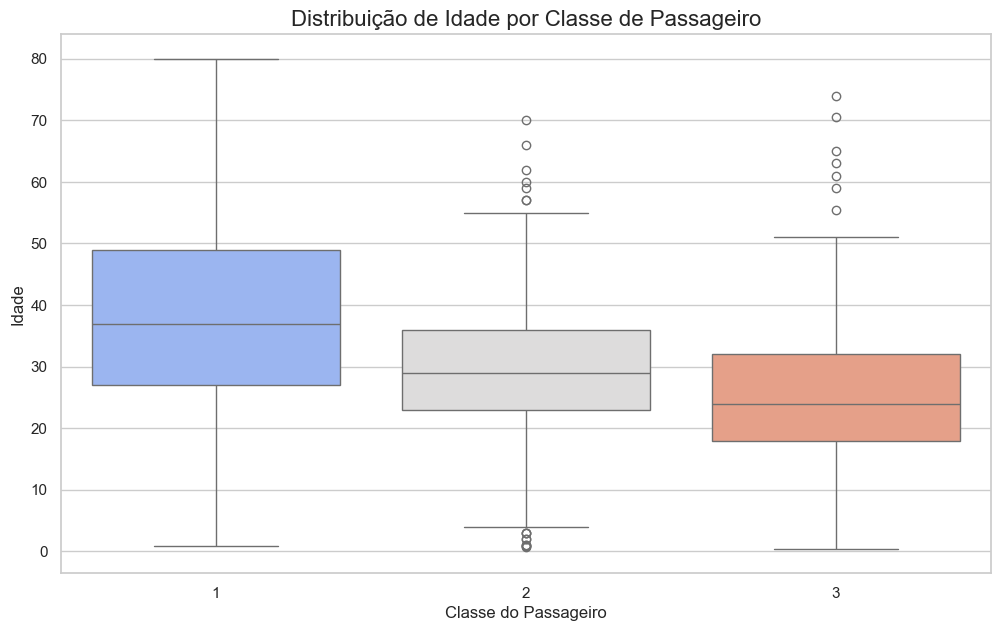

In [7]:
# 1. Importar as bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Definir um estilo visual mais agradável para os gráficos (Opcional)
sns.set_theme(style="whitegrid")

train_com_idade = train.na.drop(subset=['Age']) # trata nulos na coluna 'Age'

df_pandas = train_com_idade.toPandas()

# 4. Criar a figura e o gráfico (o Box Plot)
plt.figure(figsize=(12, 7)) # Define um bom tamanho para a visualização
sns.boxplot(
    x='Pclass',
    y='Age',
    data=df_pandas,
    palette='coolwarm' # Escolhe uma paleta de cores
)

# 5. Adicionar títulos e rótulos para deixar o gráfico claro
plt.title('Distribuição de Idade por Classe de Passageiro', fontsize=16)
plt.xlabel('Classe do Passageiro', fontsize=12)
plt.ylabel('Idade', fontsize=12)

# 6. Mostrar o gráfico
plt.show()

## Tarefa 2

### O empresário está interessado em criar um programa de fidelidade para seus clientes, mas não tem certeza de qual abordagem seria mais eficaz. Ele gostaria de saber se há alguma relação entre o gênero dos passageiros do Titanic e a sobrevivência no navio.

##### Resposta: Concluimos que a taxa de sobrevivencia dos homens foram muito maior que a das mulheres

In [8]:
train.createOrReplaceTempView('train')
spark.sql('''
    SELECT Sex, Survived, COUNT(*) AS Count
    FROM train
    GROUP BY Sex, Survived
    ORDER BY Survived desc, Sex 
''')


Sex,Survived,Count
female,1,233
male,1,109
female,0,81
male,0,468


In [9]:
summary_stats = train.agg(

    F.count(F.when(F.col('Sex') == 'male', 1)).alias('Count_Male'),
    F.count(F.when(F.col('Sex') == 'female', 1)).alias('Count_Female'),

    F.count(F.when( (F.col('Sex') == 'male') & (F.col('Survived') == 1), 1 )).alias('Count_Male_Survived'),
    F.count(F.when( (F.col('Sex') == 'female') & (F.col('Survived') == 1), 1 )).alias('Count_Female_Survived')
)

summary_stats



Count_Male,Count_Female,Count_Male_Survived,Count_Female_Survived
577,314,109,233


In [10]:
resultados = summary_stats.first()

total_male = resultados['Count_Male']
total_male_survived = resultados['Count_Male_Survived']
taxa_sobrevivencia_male = total_male / total_male_survived


total_female = resultados['Count_Female']
total_female_survived = resultados['Count_Female_Survived']
taxa_sobrevivencia_female = total_female / total_female_survived

In [11]:
taxa_sobrevivencia_male

5.293577981651376

In [12]:
taxa_sobrevivencia_female

1.3476394849785407

## Tarefa 3

### Qual a probabilidade de sobrevivência de um passageiro de primeira classe com menos de 20 anos?

##### Resposta: A probabilidade é de 80%

In [13]:
spark.sql(
    '''
    SELECT
        SUM(CASE WHEN Survived = 1 THEN 1 ELSE 0 END) / COUNT(*) AS TAXA_SOBREVIVENCIA,
        AVG(Survived) AS TAXA_SOBREVIVENCIA_variacao
    FROM
        train
    WHERE 
    Age < 20 
    AND Pclass = 1
    AND Pclass IS NOT NULL
    AND Age IS NOT NULL

    '''
)

TAXA_SOBREVIVENCIA,TAXA_SOBREVIVENCIA_variacao
0.8095238095238095,0.8095238095238095


## Tarefa 4
### Quais as principais características em comum entre os sobreviventes do desastre do Titanic?
##### Resposta: Percebemos que a maior relação dos dados em relação a sobrevivencia está muito ligado ao local de embarque 'S' e a Classe "3" e "2".

In [14]:
train.groupBy('Sex').agg(F.count('Survived'))

Sex,count(Survived)
female,314
male,577


In [15]:
# sem_nulo_train = train.dropna(subset=['Age', 'Pclass', 'Cabin', 'Embarked'])
train.groupBy( 'Pclass', 'Sex', 'Cabin', 'Embarked').agg(F.count('Survived').alias('TOTAL')).orderBy('TOTAL', ascending=False)

Pclass,Sex,Cabin,Embarked,TOTAL
3,male,NULL,S,260
2,male,NULL,S,92
3,female,NULL,S,83
2,female,NULL,S,59
3,male,NULL,C,43
3,male,NULL,Q,38
3,female,NULL,Q,33
3,female,NULL,C,22
1,male,NULL,S,16
1,male,NULL,C,11


## Tarefa 5
### É possível identificar alguma correlação entre a idade e a taxa de sobrevivência dos passageiros que embarcaram em Southampton?
##### 

In [ ]:
TRAIN_NOT_NULL = train.dropna(subset=['Age', 'Embarked'])

TRAIN_COM_FAIXA_ETARIA = TRAIN_NOT_NULL.withColumn(
    'Faixa_Etaria',
    F.when(F.col('Age') < 20, '1. Menor que 20')
     .when(F.col('Age') < 30, '2. 20 a 29 anos')
     .when(F.col('Age') < 40, '3. 30 a 39 anos')
     .when(F.col('Age') < 50, '4. 40 a 49 anos')
     .otherwise('5. 50 anos ou mais')
)


(TRAIN_COM_FAIXA_ETARIA
                      .where(F.col('Embarked').isin('S'))
                      .groupBy('Faixa_Etaria', 'Embarked')
                      .agg(F.sum(F.col('Survived')).alias('Sobreviventes'), F.count('*').alias('TOTAL'))
                      .withColumn('taxa_sobrevivencia', F.col('Sobreviventes') / F.col('TOTAL')).alias('taxa_sobrevivencia')
                      .orderBy('taxa_sobrevivencia', ascending=False)

)

Faixa_Etaria,Embarked,Sobreviventes,TOTAL,taxa_sobrevivencia
1. Menor que 20,S,54,125,0.432
3. 30 a 39 anos,S,55,131,0.4198473282442748
4. 40 a 49 anos,S,23,69,0.3333333333333333
5. 50 anos ou mais,S,17,52,0.3269230769230769
2. 20 a 29 anos,S,52,177,0.2937853107344633
